In [1]:
from __future__ import print_function
import numpy as np
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from linformer import Linformer
import glob
from PIL import Image
from itertools import chain
from vit_pytorch.efficient import ViT
from tqdm.notebook import tqdm

In [2]:
import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR   
from torch.utils.data import DataLoader, Dataset

In [3]:
from sklearn.model_selection import train_test_split  
# np.random.seed(42)

In [21]:
batch_size = 64
epochs = 50
lr = 3e-5
gamma = 0.7
seed = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

device = 'cuda'

In [5]:
train_dir = "./data/train/"
test_dir = "./data/test/"

In [6]:
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir,'*.jpg'))

In [7]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [8]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

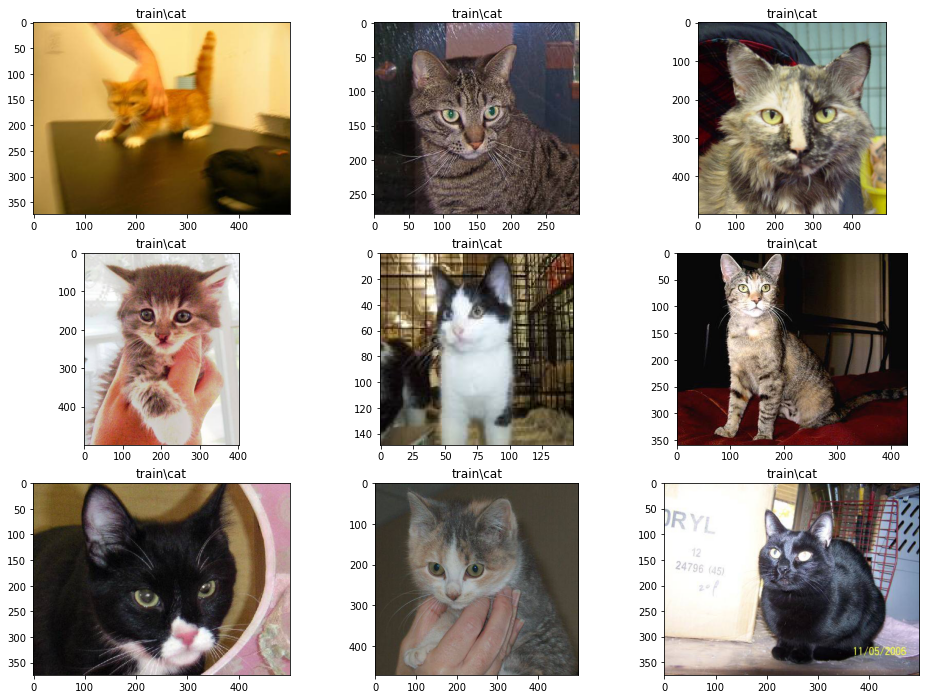

In [9]:
random_idx = np.random.randint(1, len(train_list), size = 9)
fig, axes = plt.subplots(3, 3, figsize = (16, 12))

for idx, ax in enumerate(axes.ravel()): 
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [10]:
train_list, valid_list = train_test_split(train_list, test_size = .2, stratify = labels, random_state = seed)

In [11]:
print(f"Train Data:  {len(train_list)}")
print(f"Validation Data:  {len(valid_list)}")      
print(f"Test Data:  {len(test_list)}")      

Train Data:  20000
Validation Data:  5000
Test Data:  12500


In [12]:
train_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


In [13]:
class CatsDogsDataset(Dataset):
    
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0
        return img_transformed, label

In [14]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [15]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [16]:
print(len(train_data), len(train_loader))

20000 313


In [17]:
print(len(valid_data), len(valid_loader))

5000 79


In [18]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [19]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

# loss function
# Don't use BCE loss over here since it already has  classes
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [22]:
#start training
ep, train_accuracy, val_accuracy, train_loss, v_loss = list(), list(), list(), list(), list()

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    
    ep.append(epoch)
    train_accuracy.append(epoch_accuracy)
    val_accuracy.append(epoch_val_accuracy)
    train_loss.append(epoch_loss)
    v_loss.append(epoch_val_loss)

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.0007 - acc: 1.0000 - val_loss : 0.0002 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.0001 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.0001 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [29]:
t_a

[0.9999975562095642,
 0.9999975562095642,
 0.9999975562095642,
 0.9999975562095642,
 0.9999975562095642,
 0.9999975562095642,
 0.9999975562095642,
 0.9999975562095642,
 0.9999975562095642,
 0.9999975562095642,
 0.9999975562095642,
 0.9999975562095642,
 0.9999975562095642,
 0.9999975562095642,
 0.9999975562095642,
 0.9999975562095642,
 0.9999975562095642,
 0.9999975562095642,
 0.9999975562095642,
 0.9999975562095642,
 0.9999975562095642,
 0.9999975562095642,
 0.9999975562095642]

In [27]:
t_a, v_a, t_l, v_l = list(), list(), list(), list()
for i in tqdm(range(len(val_accuracy))):
    t_a.append(train_accuracy[i].tolist())
    v_a.append(val_accuracy[i].tolist())
    # print(train_accuracy)
    t_l.append(train_loss[i].tolist())
    v_l.append(v_loss[i].tolist())

  0%|          | 0/23 [00:00<?, ?it/s]

[0.9999975562095642, 0.9999975562095642, 0.9999975562095642, 0.9999975562095642, 0.9999975562095642, 0.9999975562095642, 0.9999975562095642, 0.9999975562095642, 0.9999975562095642, 0.9999975562095642, 0.9999975562095642, 0.9999975562095642, 0.9999975562095642, 0.9999975562095642, 0.9999975562095642, 0.9999975562095642, 0.9999975562095642, 0.9999975562095642, 0.9999975562095642, 0.9999975562095642, 0.9999975562095642, 0.9999975562095642, 0.9999975562095642]


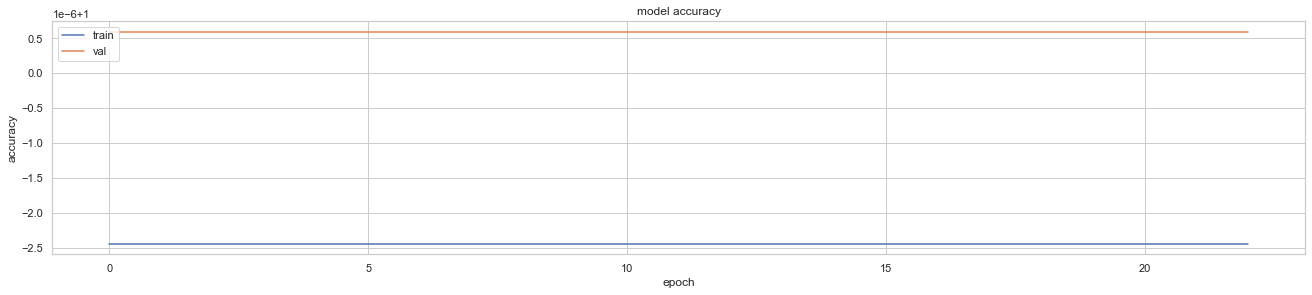

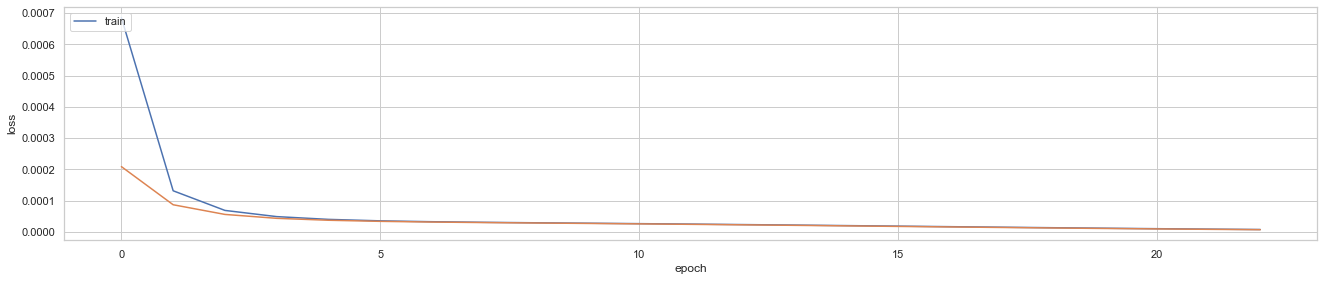

In [30]:
# summarize history for accuracy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

plt.figure(figsize = (20,4))
plt.plot(t_a)
plt.plot(v_a)
print(t_a)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('./accuracy_1.png')

# summarize history for loss
plt.figure(figsize = (20,4))
plt.plot(t_l)
plt.plot(v_l)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.savefig('./loss_1.png')